In [1]:
# %%writefile pickle_nlp_rf_model.py
%matplotlib inline
from pymongo import MongoClient
import numpy as np
import pandas as pd
import os
from my_tools import get_bill_data, process_corpus, read_jsonl_file
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix

from sklearn.externals import joblib

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# get bill data
print('-------------------')
print('Loading original and preprocessed data for vectorizing and modeling...')
data, in_progress = get_bill_data()


corpus_with_labels = read_jsonl_file('/home/ubuntu/galvanize_capstone/data/nlp/corpus_with_labels.jsonl')
corpus_df = pd.DataFrame(list(corpus_with_labels))

X = corpus_df['document']
y = corpus_df['label'].astype(int)



# create stratified train-test split
print('-------------------')
print('Doing train-test split...')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)#, random_state = 123)


# Already vectorized using pickle_nlp_boosting_model.py
# vectorizing ~30M dimensions with n-grams, l1 norm (simple avg), or l2 (avg**2)
# use_idf=True gives more weight to words, n_grams that appear less frequently in the corpus
# sublinear_tf=True reduces the bias of length
print('-------------------')
print('Vectorizing...')
tfvect = TfidfVectorizer(ngram_range = (1, 4), 
                         max_features = 6000000,
                         norm = 'l2',              #default value
                         use_idf = True,           #default value
                         sublinear_tf = True)



# # load the TfidfVectorizer if needed
# print('-------------------')
# print('Loading the pickled TfidfVectorizer...')
# pickle_path = 'pickle_files/tfidfVectorizer.pkl'
# tfvect = joblib.load(pickle_path)
# print('Pickled vectorizer loaded.')


# print('-------------------')
# print('Vectorizing bill text...')
X_train_vec = tfvect.fit_transform(X_train)
# X_train_vec = tfvect.transform(X_train)           # for pickled model
X_test_vec = tfvect.transform(X_test)


print('-------------------')
print('Getting Features...')
features = tfvect.get_feature_names()


# dump the TfidfVectorizer
print('-------------------')
print('Pickling the TfidfVectorizer...')
pickle_path = 'pickle_files/tfidfVectorizer.pkl'
if os.path.exists(pickle_path):
    os.remove(pickle_path)
joblib.dump(tfvect, pickle_path)
print('Pickling complete.')


print('-------------------')
print('Training Random Forest Classifier with vectorized results...')
rf = RandomForestClassifier(n_estimators = 100, 
                            max_features = 3000000,
                            max_depth = 3, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1,
                            class_weight = 'balanced',
                            n_jobs = -1)
rf.fit(X_train_vec, y_train)

rf_y_pred = rf.predict(X_test_vec)
rf_y_pred_proba = rf.predict_proba(X_test_vec)

print('F1 Score:\t\t{:.4f}'.format(f1_score(y_test, rf_y_pred)))
print('Recall Score:\t\t{:.4f}'.format(recall_score(y_test, rf_y_pred)))
print('Precision Score:\t{:.4f}'.format(precision_score(y_test, rf_y_pred)))
print('Accuracy Score:\t\t{:.4f}'.format(accuracy_score(y_test, rf_y_pred)))
print('Confusion Matrix')
print(confusion_matrix(y_test, rf_y_pred))


# dump the RandomForest Classifier
print('Pickling the Random Forest Classifier...')
pickle_path = 'pickle_files/nlp_randomForest.pkl'
if os.path.exists(pickle_path):
    os.remove(pickle_path)
joblib.dump(rf, pickle_path)
print('All Pickling Complete.  DATA SCIENCE!!!')

-------------------
Loading original and preprocessed data for vectorizing and modeling...
-------------------
Doing train-test split...
-------------------
Vectorizing...
-------------------
Getting Features...
-------------------
Pickling the TfidfVectorizer...
Pickling complete.
-------------------
Training Random Forest Classifier with vectorized results...
F1 Score:		0.2961
Recall Score:		0.9445
Precision Score:	0.1755
Accuracy Score:		0.8465
Confusion Matrix
[[12888  2400]
 [   30   511]]
Pickling the Random Forest Classifier...
All Pickling Complete.  DATA SCIENCE!!!


Text(0.5,0,'Average contribution to information gain')

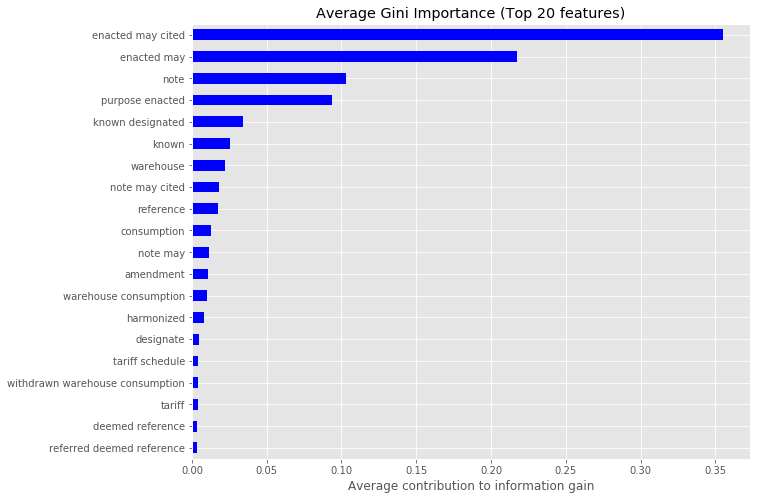

In [4]:
#exploration
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=features)

feat_scores = feat_scores.sort_values()[::-1][:15][::-1]

fig = plt.figure(figsize = (8, 8))
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance (Top 20 features)')
ax.set_xlabel('Average contribution to information gain')

In [ ]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=features)

feat_scores = feat_scores.sort_values()[::-1][:50][::-1]

ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance (Top 50 features)')
ax.set_xlabel('Average contribution to information gain')

In [ ]:
rf.n_estimators

In [ ]:
confusion_matrix(y_test, rf_y_pred)

In [ ]:
pd.Series(rf_y_pred_proba[:, 1]).unique()

In [ ]:
rf_y_pred_proba[45, 1]

In [ ]:
# Get input of bill still in progress
input_corpus = process_corpus(in_progress, 'bill_text')

input_vec = tfvect.transform(input_corpus)
input_y_pred = rf.predict(input_vec)
input_y_pred_proba = rf.predict_proba(input_vec)


print(input_y_pred_proba)

In [ ]:
# rf_y_pred_proba[0]

In [ ]:
# my recall scores seem abnormally high... let's iterate through a few different slices to build 
# confidence in our results
recall_scores = []

i = 1
while i < 6:
    print('-------------')
    print('Performing train-test split and vectorizing for iteration {}...'.format(i))
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y)
    
    tfvect = TfidfVectorizer(ngram_range=(1, 5))
    X_train_vec = tfvect.fit_transform(X_train)
    X_test_vec = tfvect.transform(X_test)
    
    print('\tFitting data to Random Forest Classifier...')
    rf = RandomForestClassifier(max_features = 'auto', n_jobs = -1)
    rf.fit(X_train, y_train)

    rf_y_pred = rf.predict(X_test)
    recall_scores.append(recall_score(y_test, rf_y_pred))
    
    i+=1
    

print('Mean recall score after {} iterations: {}'.format(i, np.mean(recall_scores)))